Note:

This notebook represents some of my very first coding practices.

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import re
from sklearn import preprocessing

# dataset from: https://www.kaggle.com/andrewmvd/heart-failure-clinical-data
df = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')

# $p(smoker|sex)$:


In [2]:
female = df.loc[df['sex']==0, ['smoking']]
male = df.loc[df['sex']==1, ['smoking']]

female_count = female.size
male_count = male.size

smoker_f_count = female.loc[female['smoking']==1, :].size
smoker_m_count = male.loc[male['smoking']==1, :].size

non_smoker_f_count = female_count - smoker_f_count
non_smoker_m_count = male_count - smoker_m_count

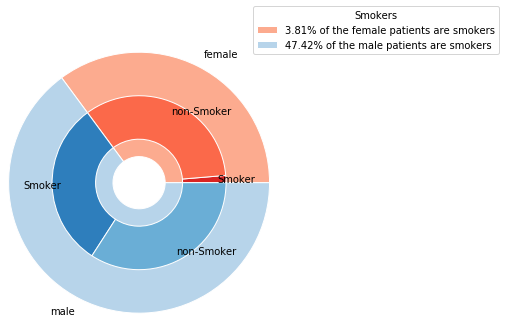

In [3]:
# colors by colormap
color_f, color_m = [plt.cm.Reds, plt.cm.Blues]

# outer
outer_names = ['female', 'male']
outer_size = [female_count, male_count]
fig, ax = plt.subplots()
pie_outer, _ = ax.pie(outer_size, radius=1.5, labels=outer_names, colors=[color_f(0.3), color_m(0.3)] )
plt.setp( pie_outer, width=1.2, edgecolor='white')
 
# inner
inner_names = ['Smoker', 'non-Smoker', 'Smoker', 'non-Smoker']
inner_size = [smoker_f_count, non_smoker_f_count, smoker_m_count, non_smoker_m_count]
pie_inner, _ = ax.pie(inner_size, radius=1, labels=inner_names, labeldistance=0.9, colors=[color_f(0.7), color_f(0.5), color_m(0.7), color_m(0.5)])
plt.setp(pie_inner, width=0.5, edgecolor='white')
plt.margins(0,0)

# plot a legend containing the probabilities of a sample of each sex being a smoker:
probabilities = pd.Series({'female': str(round((smoker_f_count / female_count)*100,2)), 
                           'male': str(round((smoker_m_count / male_count)*100, 2))})
labels = pd.Series({'female': probabilities['female'] + '% of the female patients are smokers', 
                    'male': probabilities['male'] + '% of the male patients are smokers'})
plt.legend(labels, title="Smokers", loc="center left", bbox_to_anchor=(1, 0.7, 0.5, 1))

plt.show()

# goal: correlation between smoking and diabetes of patients of different ages

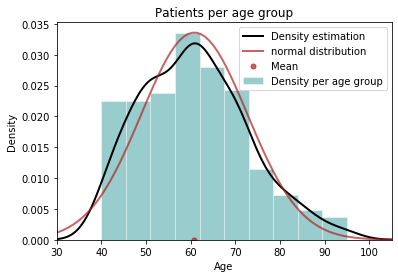

In [4]:
ages = df['age']

fig, ax = plt.subplots(figsize = (6,4))
# histogram:
ages.plot(kind = "hist", density = True, bins = 10, color='teal', alpha=0.4, edgecolor='white', label='Density per age group')

# kernel density estimation:
ages.plot(kind = "kde", color='black', linewidth=2, label='Density estimation')

# normal distribution:
mu = ages.values.mean()
sigma = ages.values.std()
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='firebrick', alpha=0.7, linewidth=2, label='normal distribution')
plt.plot(mu, 0, 'o', c='firebrick', markersize=5, alpha=0.7, label='Mean')

plt.legend()
ax.set_xlim(ages.values.min()-10, ages.values.max()+10)
ax.set_xlabel("Age")
ax.set_title("Patients per age group")
plt.show()

# goal: Pattern Mining to detect frequent sets of patient conditions

## preprocessing:

### centralize the feature values in order to obtain less complex categorical data in each column: 

Let's ignore the age of the patients for simplicity

One could have used the following or something similar to 
transform it into categorical data:
the patients who are older or exactly as old as the mean (=1) 
and the patients who are younger than the mean (=-1)

In [8]:
# mask_old = df_p['age'] >= df_p['age'].values.mean()
# df_p.loc[mask_old, ['age']] = 1
# df_p.loc[df_p['age'] != 1, ['age']] = -1

In [9]:
# the follow-up period isn't interesting for us in this case:
# df_p := data frame pattern mining
cols = pd.Series(df.columns).drop([0,11])
df_p = df.loc[:, cols]



def centralize(att, lower, upper):
    '''
    att: attribute which has to be centralized,
    lower: lower limit for normal values,
    upper: upper limit for normal values
    
    replaces normal values by None, too low values by -1 and too high values by 1
    '''
    mask_normal = (df_p[att] >= lower) & (df_p[att] <= upper)
    mask_lower = (df_p[att] < lower) & (df_p[att] != 0)
    mask_higher = df_p[att] > upper
    df_p.loc[mask_normal, [att]] = 0
    df_p.loc[mask_lower, [att]] = -1
    df_p.loc[mask_higher, [att]] = 1 
    
    
    
# https://www.mountsinai.org/health-library/tests/creatine-phosphokinase-test
# -> normal value: 10 to 120 mcg/L
centralize('creatinine_phosphokinase', lower=10, upper=120)

# https://www.heart.org/en/health-topics/heart-failure/diagnosing-heart-failure/ejection-fraction-heart-failure-measurement
# -> normal value: 50 to 70 percent
centralize('ejection_fraction', lower=50, upper=70)

# https://www.ucsfhealth.org/medical-tests/003647
# -> normal value: 150,000 to 400,000 p/mcl
centralize('platelets', lower=150_000, upper=400_000)

# https://www.medicinenet.com/creatinine_blood_test/article.htm
# simplified -> normal value: 0.5 to 1.2 mg/dL
centralize('serum_creatinine', lower=0.5, upper=1.2)

# https://www.ucsfhealth.org/medical-tests/003481
# -> normal value: 135 to 145 mEq/L
centralize('serum_sodium', lower=135, upper=145)

# for uniformity( + convert int64 to int8)
df_p = df_p.astype(np.int8)

### transform the data into the Market Basket format

In [10]:
# One-Hot-Encoding:
df_e = pd.get_dummies(df_p, columns=df_p.columns)

# df_e := dataframe encoded
# convert 0->None
df_e = df_e.replace(to_replace=[0], value=[None])

## Apriori Algorithm

High-level explanation of market basket analysis via Apriori: https://www.youtube.com/watch?v=WGlMlS_Yydk&t=683s

Apriori is an easy to implement algorithm to find frequent sets of feature values in multiple observations. Unfortunately, Apriori is a bottom-up algorithm and finds frequent sets of size N based on already found frequent sets (including singletons) of size N-1. Thus, the algorithm is time and space complex. 

In [11]:
# support threshold (to define if a set is frequent or not):
# to plot some 'frequent' sets with setsize:7 use s_t=0.12
# to plot some 'frequent' sets with setsize:5 use s_t=0.26
# to plot some 'frequent' sets with setzize:4 use s_t=0.32
# to plot some 'frequent' sets with setsize:3 use s_t=0.42
s_t = 0.12

# <TODO>: prevent saving duplicates and unsupported sets instead of deleting them in the end
def prune(sets, df):
    '''
    sets: combinations of features
    df: dataframe which contains the feature values
    
    returns all sets whith a support > support threshold(s_t) in the dataframe
    '''
    supported = []
    for set_possible in sets:
        df_match = df.iloc[:,set_possible]==1
        if df.loc[df_match.all(axis=1),:].shape[0] / 299 > s_t:
            supported.append(set_possible)
    return supported



def combine(sets_f, n):
    '''
    sets_f: a list containing feature sets in inner lists
    n: setsize(len) of each inner list in sets_f
    
    combines two sets, if the intersection of the two sets has n-1 elements.
    returns all combinations. The combination of two sets is the union of the sets.
    '''
    # use a list of unchecked sets to avoid symmetric combinations (avoid: combination a&b and b&a)
    unchecked = pd.DataFrame(sets_f)
    combinations = []
    
    # the intersection of two singletons has always n-1 = 0 elements
    if(n==1):
        for i,set_f in enumerate(sets_f):
            unchecked = unchecked.drop(i)
            for set_other in unchecked.values:
                combi_possible = np.union1d(set_f, set_other)
                combinations.append(combi_possible)
    else:
        for i,set_f in enumerate(sets_f):
            unchecked = unchecked.drop(i)
            for set_other in unchecked.values:
                if (np.intersect1d(set_f, set_other)).shape[0] == n-1:
                    combi_possible = np.union1d(set_f, set_other)
                    combinations.append(combi_possible)
    combinations_unique = []
    return list(np.unique(combinations, axis=0))
    
    
    
# frequent items:
counts = df_e.count(axis='rows')
# support for each item:
counts = counts / df_e.shape[0]
# drop all infrequent features
mask_frequent_items = counts.values > s_t
df_dropped = df_e.loc[:,mask_frequent_items]



# encode the frequent features as integers(so we solely have to deal woth integers):
feature_encoding = pd.DataFrame({'feature':df_dropped.columns,
                                 'encoding':np.arange(0, df_dropped.columns.size)})
combis = list(feature_encoding.encoding)


setsize = 1
frequent_sets = [combis]
for i in range(10):
    setsize = i+1
    combis = prune(combine(combis, setsize), df_dropped)
    # no more frequent sets are found:
    if combis==[]:
        break
    frequent_sets.append(combis)

### plot the results:

You maybe need to adjust the figsize in line 75, depending on the chosen s_t.

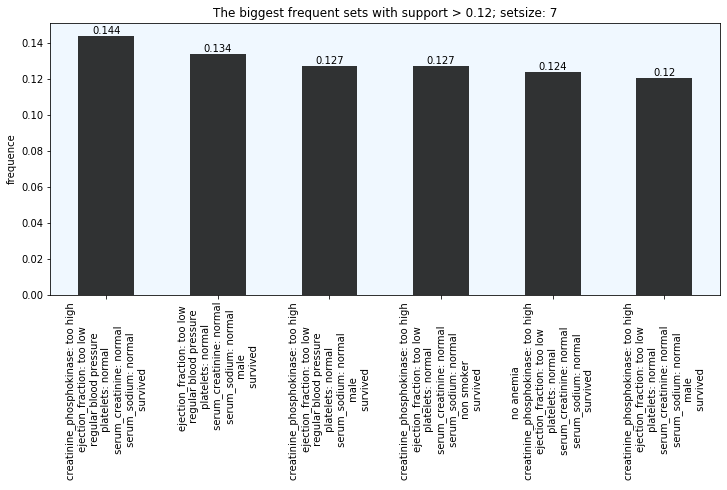

In [12]:
def frequence(vis, df):
    '''
    vis: 'very important set', the biggest frequent sets of features
    df: dataframe which contains the features in vis
    
    returns the frequence of the very important set in the df
    '''
    df_match = df.iloc[:,vis]==1
    return df.loc[df_match.all(axis=1),:].shape[0] / 299



def feature_plot(indices):
    '''
    indices: represent features in the dataframe
    
    returns the concatenated feature names, related to the indices
    to plot them in a bar chart.
    '''
    string = ''
    for i in indices:
        for j in feature_encoding['feature'].loc[indices]:
            string.join(j + "\n")
    return string


    
def decode(feature):
    '''
    feature: a feature/column name contained in the dataset
    
    returns the string representation of the feature
    '''
    return feature_encoding['feature'][feature]



def clean(feature_series):
    '''
    feature_series: a series containing uncleaned string representation of the features.
    
    returns the cleaned feature_series. cleaning means changing the strings within the series
    in order to obtain better understandable strings
    '''
    # binary features.. (I hope that I covered all of them now :D):
    feature_series = feature_series.apply(lambda x : re.sub('DEATH_EVENT_0', 'survived', x))
    feature_series = feature_series.apply(lambda x : re.sub('DEATH_EVENT_1', 'dead', x))
    feature_series = feature_series.apply(lambda x : re.sub('sex_0', 'female', x))
    feature_series = feature_series.apply(lambda x : re.sub('sex_1', 'male', x))
    feature_series = feature_series.apply(lambda x : re.sub('diabetes_0', 'no diabetes', x))
    feature_series = feature_series.apply(lambda x : re.sub('diabetes_1', 'diabetes', x))
    feature_series = feature_series.apply(lambda x : re.sub('anaemia_0', 'no anemia', x))
    feature_series = feature_series.apply(lambda x : re.sub('anaemia_1', 'anemia', x))
    feature_series = feature_series.apply(lambda x : re.sub('high_blood_pressure_0', 'regular blood pressure', x))
    feature_series = feature_series.apply(lambda x : re.sub('high_blood_pressure_1', 'high blood pressure', x))
    feature_series = feature_series.apply(lambda x : re.sub('smoking_0', 'non smoker', x))
    feature_series = feature_series.apply(lambda x : re.sub('smoking_1', 'smoker', x))
    
    # other features:
    feature_series = feature_series.apply(lambda x : re.sub('_0', ': normal', x))
    feature_series = feature_series.apply(lambda x : re.sub('_-1', ': too low', x))
    return feature_series.apply(lambda x : re.sub('_+1', ': too high', x))



def vis_plot(viss):
    '''
    viss: a df containing the frequence and the items of the biggest
    frequent sets(Very Important SetS)
    
    plots the biggest frequent sets in descending order in a bar chart.
    '''
    # DECODE THE FEATURE NAMES TO HAVE A USER FRIENDLY PLOT:
    mask_ex_freq = np.arange(start=1, stop=len(frequent_sets[-1][0])+1, step=1) 
    df_decode = pd.DataFrame(df_vis.loc[:, mask_ex_freq])
    # creates an MxM dataframe (M:= number of occuring features) containing Null-values
    df_decode = df_decode.apply(decode, axis=1)
    # replace the null values (else they would appear in the resulting strings)
    df_decode = df_decode.fillna('')
    # merge all strings per row into one series, each value corresponds to one row of the former df
    ser_decode = df_decode.apply(lambda x :' '.join(x.astype(str)), axis=1)
    # add \n between the features in each string for better readability in the plot:
    ser_decode = ser_decode.apply(lambda x : re.sub(' +', '\n ', x.lstrip()))
    # replace some substrings for better readability:
    ser_decode = clean(ser_decode)
    
    ########################################################
    ## PLOT THE BAR CHART:
    df_plot = pd.concat([df_vis[0], ser_decode], keys=['frequence', 'bin_names'], axis=1)
    plt.figure(figsize=(12,5))
    ax = df_plot['frequence'].plot(kind='bar', color='black', alpha=0.8)
    ax.set_title(f'The biggest frequent sets with support > {s_t}; setsize: {len(frequent_sets[-1][0])}')
    ax.set_ylabel('frequent sets')
    ax.set_ylabel('frequence')
    ax.set_xticklabels(df_plot['bin_names'])
    ax.set_facecolor('aliceblue')
    # add bar labels on top of the bars
    bars=ax.patches
    for bar, frequence in zip(bars, df_plot['frequence']):
        height = bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2, height, round(frequence,3),
                ha='center', va='bottom')
    plt.show()

        
        
## sort the biggest frequent sets according to their frequence (in descending order)
# obtain the frequence of each frequent set:
frequences = []
for vis in frequent_sets[-1]:
    frequences.append(frequence(vis, df_dropped))
# stack the frequences and the vis together and sort them:
values_vis = np.vstack([frequences,np.array(frequent_sets[-1]).T]).T
df_vis = pd.DataFrame(values_vis).sort_values(by=[0], ascending=False, ignore_index=True)

vis_plot(df_vis)

We want to gain as much knowledge about the patients condition as possible with as few effort as possible. Thus we should firstly acquire the feature, which occures in most frequent sets, ...

Let's determine which features are the 'most valuable' (i.e. which features occure often within frequent sets) with respect to the total occurance of the feature:

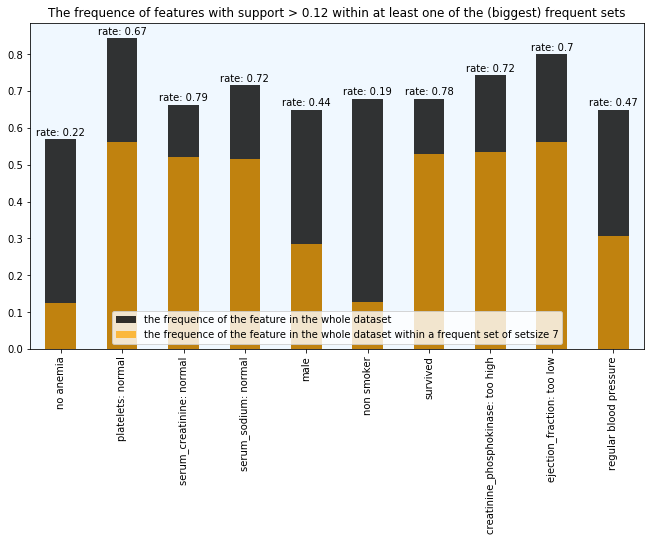

In [14]:
def vif_plot(viss, df_total, setsize, supp_t):
    '''
    viss: a df containing the frequence and the items of the biggest
    frequent sets(Very Important SetS).
    df: a df containing all features and ones in a column, if the patient shares 
    the corresponding condition.
    setsize: the size of the frequent sets
    supp_t: support threshold of the apriori algorithm, used for the plot only
    
    the rarer a feature is in the dataset df_total and the more frequent 
    a feature occurs in the biggest frequent sets, the more valuable is the feature.
    
    plots the frequence of the feature in the whole dataset and the frequence of the
    feature within at least one of the biggest frequent sets.
    (<TODO>: plots the score of each feature; score: how many of the
    biggest frequent sets contain the feature and how common is thi frequent set?
    normalized)
    '''
    weights = viss[0]
    # one-hot encoding(all cols but the frequence):
    viss = pd.get_dummies(viss.iloc[:, np.arange(start=1, stop= setsize+1)], 
                          columns=viss.iloc[:, np.arange(start=1, stop= setsize+1)].columns)
    def trunc(string):
        return string[2:]
    new_cols = pd.Series(viss.columns).apply(trunc)
    viss.columns = new_cols
    viss = viss.groupby(level=0, axis=1).sum()
    
    #################################################################################
    # CALCULATE THE FREQUENCE OF EACH FEATURE IN THE DATASET WITHIN ONE OF THE BIGGEST FREQUENT SETS:
    # get combinations per feature that form a frequent set:
    df_frequent_combis = pd.DataFrame()
    
    def find_freq_combis(col):
        '''
        col: a column representing a feature
        
        saves the features which form a frequent set with the feature of the given col 
        in the columns of df_frequent_combis and fills them with Null values
        in order to provide matching columns sizes.
        '''
        feature = col.name
        # only rows containing the feature
        feature_occures = viss.loc[viss[feature]==1, :]
        # only the (decoded) column names of cols, which equal 1 in combination if the feature occures
        col_mask = (feature_occures != 0).any(axis=0)
        combis = feature_occures.columns[col_mask]
        combis_decoded = pd.Series(combis).astype(float).apply(decode)
        # fill with Null values in order to obtain matching dimensions
        filler = pd.Series([None]*(viss.columns.size - combis_decoded.size), dtype='float64')
        filled = pd.concat([combis_decoded, filler], ignore_index=True)
        df_frequent_combis[decode(float(feature))] = filled
    
    # column wise
    viss.apply(find_freq_combis, axis=0)
    
    # check how often the feature occures in the dataset within at least one frequent set:
    # TODO: via apply?
    occurance_in_freq_set = dict()
    for feature in df_frequent_combis.columns.values:
        columns_combinable = df_frequent_combis[feature][df_frequent_combis[feature].notna()].values
        df_combinable = df_total.loc[:, columns_combinable]
        df_combinable = df_combinable.loc[((df_combinable.sum(axis=1) >= setsize) & df_combinable[feature]==1), :]
        occurance_in_freq_set.update({feature: df_combinable.shape[0]/299}) 
        
    #################################################################################
    # CALCULATE THE SCORES: 
    viss = viss.multiply(weights, axis=0)
    scores = viss.sum(axis=0)
    # max/min normalization:
    scores_sub_min = scores - np.min(scores.values) 
    scores_normalized = scores_sub_min / np.max(scores_sub_min.values)
    scores_normalized.index = pd.Series(scores_normalized.index).astype(float).apply(decode)
    
    #################################################################################
    # CALCULATE THE OVER ALL FREQUENCE OF EACH FEATURE IN THE DATASET:
    # the over all frequence of the feature in df_total:
    features = pd.Series(viss.columns).astype(float).apply(decode)
    frequence_overall = df_total[features]
    frequence_overall = frequence_overall.count(axis=0) / 299
    
    #################################################################################
    # MERGE ALL 3 SERIES TOGETHER AND PLOT THEM:
    # note: the indices are already in the same order, but this would align them anyway:
    df_plot_vif = pd.concat([scores_normalized, frequence_overall, pd.Series(occurance_in_freq_set)], 
                            axis=1, keys=['scores', 'frequence', 'occurance_in_freq_set'])
    df_plot_vif.index = clean(pd.Series(df_plot_vif.index))
    # add a rate: occurance in a frequent set / occurance in the dataset(labels above bars) and 
    # save it in a user friendly string:
    df_plot_vif['rate'] = df_plot_vif['occurance_in_freq_set']  / df_plot_vif['frequence'] 
    def rate_to_string(rate):
        return f'rate: {round(rate,2)}'
    df_plot_vif['rate_string'] = df_plot_vif['rate'].apply(rate_to_string)
    
    # plot:
    # might adjust the figsize acording to the s_t value
    plt.figure(figsize=(11,6))
    ax1 = df_plot_vif['frequence'].plot(kind='bar', color='black', alpha=0.8,
                                       label='the frequence of the feature in the whole dataset')
    ax1.set_xticklabels(df_plot_vif.index)
    ax1.set_facecolor('aliceblue')
    ax2 = df_plot_vif['occurance_in_freq_set'].plot(kind='bar', color='orange', alpha=0.7, label=f'the frequence of the feature in the whole dataset within a frequent set of setsize {setsize}')
    ax2.set_title(f'The frequence of features with support > {s_t} within at least one of the (biggest) frequent sets')
    # add bar labels on top of the bars (ax 1 to plot it above total frequence)
    bars=ax1.patches
    for bar, rate in zip(bars, df_plot_vif['rate_string']):
        height = bar.get_height()
        # might adjust the height value according to the s_t value
        ax1.text(bar.get_x()+bar.get_width()/2, height + 0.005, rate, ha='center', va='bottom')
    # plot the legend:
    plt.legend(loc='lower center')
    plt.show()

vif_plot(df_vis, df_e, setsize, s_t)